In [3]:
# import torch
import glob
import numpy as np
import pandas as pd
from math import sqrt
from datetime import datetime
from matplotlib import pyplot
from pandas.core.common import flatten

# from torch import nn, optim
from pickle import dump
from pickle import load
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

In [4]:
valves = ["20-LV-1031_Z_X_Value", "20-LV-1031_Z_Y_Value", "20-LV-1034_Z_X_Value",
              "20-LV-1034_Z_Y_Value", "20-PV-1037_Z_X_Value", "20-PV-1037_Z_Y_Value"]

In [5]:
alarm = '1031_L'

In [21]:
def create_df(valve_name):
    """ Returns a dataset of specific valve column."""
    
    dfs = {file.split("_")[-4]: pd.read_pickle(file) for file in \
           glob.glob("S:\SRH\BDBA_Sem_2\Case_study_1\data\*.pkl")}
    
    dfs_sorted = dict(sorted(dfs.items()))
    df_single = pd.concat(dfs_sorted, axis=0)

    valve_df = df_single.filter([valve_name])
    valve_df = valve_df.droplevel(0, axis=0)
    return valve_df

In [22]:
valve_df = create_df('20-LV-1031_Z_Y_Value')

In [23]:
def preprocessed_df(df, val_pct):
    """ Creates train, validation and test set after applying normalisation of all feature cols
    Args:
    df: dataframe object
    val_pct: percentage size of validation plus test size (float)
    """
    
    val_data_size = round(df.shape[0] * 0.3)
    test_data_size = round(val_data_size * 0.1)
    
    train_data = df[:-val_data_size]
    val_data = df[-val_data_size:-test_data_size]
    test_data = df[-test_data_size:]
    
    # Scaling the data
    scalar = MinMaxScaler()
    scalar.fit(train_data.values.reshape(-1,1)) # sklearn scalars accepts 2d arrays to scale hence reshaping the data
    # save the scaler
    dump(scalar, open('model_objects_'+alarm+'\scaler_ts.pkl', 'wb'))

    train_scaled = scalar.transform(train_data.values.reshape(-1,1)) # pandas does'nt have .reshape() hence by calling the values and then applying underlying numpy reshape
    val_scaled = scalar.transform(val_data.values.reshape(-1,1))
    test_scaled = scalar.transform(test_data.values.reshape(-1,1))

    df_train = pd.DataFrame(train_scaled)
    df_val = pd.DataFrame(val_scaled)
    df_test = pd.DataFrame(test_scaled)
    
    return df_train, df_val, df_test

In [24]:
df_train, df_val, df_test = preprocessed_df(valve_df, 0.3)

In [25]:
# Creating small input sequences
def input_sequence(data, seq_len):
    """ Creates a small input sequence of a given seq length and 
        returns two numpy arrays asinpuy and output sequence
        
        Args:
        data = input dataframe
        seq_len = integer number

        """
    input_x = []
    output_y = []
    
    for i in range(len(data)-seq_len-1):
        in_x = data[i:(i+seq_len)]
        out_y = data[i+seq_len]
        
        input_x.append(in_x)
        output_y.append(out_y)
    
    return np.array(input_x), np.array(output_y)

In [26]:
train_values = df_train.values.astype('float32')
val_values = df_val.values.astype('float32')
test_values = df_test.values.astype('float32')
# specify the window size
n_steps = 15
# split into samples
X_train, y_train = input_sequence(train_values, n_steps)
X_val, y_val = input_sequence(val_values, n_steps)
X_test, y_test = input_sequence(test_values, n_steps)
# reshape into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [27]:
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(16673, 15, 1) (6422, 15, 1) (699, 15, 1) (16673, 1) (6422, 1) (699, 1)


In [28]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_steps,1)))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# configure early stopping
es = EarlyStopping(monitor='val_loss', patience=6)
    
# Visualise model
logdir = "logs/ts_"+alarm+"/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=logdir)


# fit the model
model_history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2, 
                            validation_data=(X_val, y_val), callbacks=[es, tensorboard])
    
# save model to file
model.save('model_time_series_'+alarm+'.h5')
    
# evaluate the model
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, sqrt(mse), mae))

Epoch 1/100
522/522 - 19s - loss: 0.1258 - mae: 0.2098 - val_loss: 0.0044 - val_mae: 0.0533
Epoch 2/100
522/522 - 10s - loss: 0.0067 - mae: 0.0603 - val_loss: 0.0026 - val_mae: 0.0401
Epoch 3/100
522/522 - 10s - loss: 0.0054 - mae: 0.0542 - val_loss: 0.0019 - val_mae: 0.0383
Epoch 4/100
522/522 - 10s - loss: 0.0057 - mae: 0.0560 - val_loss: 0.0021 - val_mae: 0.0341
Epoch 5/100
522/522 - 10s - loss: 0.0059 - mae: 0.0569 - val_loss: 0.0042 - val_mae: 0.0577
Epoch 6/100
522/522 - 10s - loss: 0.0060 - mae: 0.0576 - val_loss: 0.0017 - val_mae: 0.0364
Epoch 7/100
522/522 - 10s - loss: 0.0060 - mae: 0.0572 - val_loss: 0.0013 - val_mae: 0.0286
Epoch 8/100
522/522 - 12s - loss: 0.0060 - mae: 0.0567 - val_loss: 0.0031 - val_mae: 0.0508
Epoch 9/100
522/522 - 9s - loss: 0.0058 - mae: 0.0563 - val_loss: 0.0023 - val_mae: 0.0413
Epoch 10/100
522/522 - 10s - loss: 0.0054 - mae: 0.0540 - val_loss: 0.0030 - val_mae: 0.0497
Epoch 11/100
522/522 - 10s - loss: 0.0053 - mae: 0.0535 - val_loss: 0.0013 - val

In [17]:
# save model to file
# model.save('model_time_series.h5')

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 48,651
Trainable params: 48,551
Non-trainable params: 100
__________________________________________________

In [30]:
# summarize the model
plot_model(model, 'model.png', show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


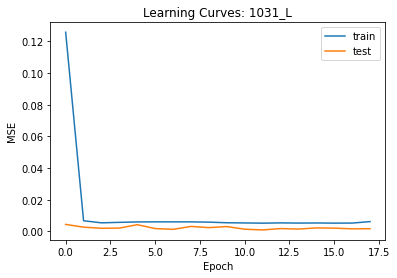

In [31]:
# plot learning curves
pyplot.title(f'Learning Curves: {alarm}')
pyplot.xlabel('Epoch')
pyplot.ylabel('MSE')
pyplot.plot(model_history.history['loss'], label='train')
pyplot.plot(model_history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [34]:
model = load_model('S:\SRH\BDBA_Sem_2\Case_study_1\models_caseStudy\model_time_series_'+alarm+'.h5')

In [38]:
# load the scaler
scalar = load(open('S:\SRH\BDBA_Sem_2\Case_study_1\models_caseStudy\model_objects_'+alarm+'\scaler_ts.pkl', 'rb'))

In [39]:
yhat = model.predict(X_test)
yhat = scalar.inverse_transform(yhat)

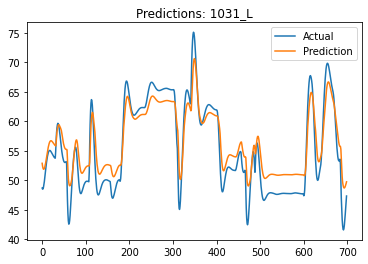

In [43]:
pyplot.plot(scalar.inverse_transform(y_test), label="Actual")
pyplot.plot(yhat, label="Prediction")
pyplot.legend()
pyplot.title(f'Predictions: {alarm}')
pyplot.savefig(f'{alarm}.png')

In [41]:
def is_alarm(pred_val, alarm_name):
    """ This is a classification for alarm based on specific threshold value.
    Args:
    pred_val: list of predicted valve values
    alarm_name: Name of the specific alarm
    """
    threshold_dict = {"1031_H":2.2, "1031_L":1.5, "1034_H":0.9, "1031_L":0.7, "1037_H":24, "1031_L":21}
    
    is_alarm = [1 if val >= threshold_dict[alarm_name] else 0 for val in pred_val]
    
    return is_alarm  

In [42]:
is_alarm(yhat, alarm)

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
